## Carbon emissions due to land use change

Based on the [exploratory document](https://docs.google.com/document/d/19D1WKgLqVelLlG98aHHoYxhaj6VJHH4bcRTPY33HmJ8/edit#heading=h.g8tlcpcbnmgq) we propose the calculation of carbon emissions due to land use change. TO that end, we will need to compute first the land use change impact using tree cover loss data as it's explained in the 3_deforestation_indicator noteebok. Once we have extimated the deforestation risk due to land use change for a specific commodity we can calculate the related carbon emissions using the ipcc recommendations. 

Therefore, the formula to calculate the carbon emissions due to land use change would be:

    Carbon emissions due to land use change (tCO2e / year)  =  total tree cover area lost (Hectare) * Net forest GHG flux - 2001-2020 (tCO₂e / Hectare) * 10000/19 (unit conversion) *   probability purchase area (unitless) 

Where: 

- Probability purchase area is the potential area where a certain commodity has been purchased from. The calculation of this probability purchase area has been done in the 05_probability_area notebook and on the 0_2_biodiversity_indicator notebook for a test location in indonesia.

- Total tree cover area lost (Hectare) would be the total tree cover loss detected using Hansen data (Satelligence data). This approach is reflected in the 0_3_Deforestation:Risk notebook.

- Net forest GHG flux - 2001-2020 (tCO₂e / Hectare)  represents the net exchange of carbon between forests and the atmosphere between 2001 and 2020, calculated as the balance between carbon emitted by forests and removed by (or sequestered by) forests.

- The division by 19 to obtain average annual net GHG flux and the multiplication by 10000 to ha.

The datasets that we will use are:

- Net forest GHG flux - 2001-2020 (tCO₂e / Hectare) * 10000/19 (unit conversion) from gfw
- tree cover loss detection from satelligence

NOTE: For the prototype we will be using the earthstat carbon emissions dataset to estimate the ghg emissions due to land use change.


## Table of Contents
- ### [1. Import libraries](#libraries)
- ### [2. Carbon emissions due to land use change risk](#risk)
    - #### [2.1 Explore carbon datasets](#carbon)
    - #### [2.2 Explore deforestation datasets](#deforestation)
    - #### [2.3 Calculate risk map](#risk_map)
- ### [3. Carbon emissions due to land use change metric](#metric)
    - #### [3.1 Probability purchase area](#purchase_area)
    - #### [3.2 Calculation of the carbon emissions metric](#carbon_metric)
- ### [4. Final notes](#finalNotes)


<a id='libraries'></a>
## 1. Import libraries

In [1]:
# import lib
import os
import io
import requests
import zipfile

import rasterio as rio
import rasterio.plot
import matplotlib.pyplot as plt
from rasterio.plot import show_hist

<a id='risk'></a>
## 2. Carbon emissions due to land use change risk

THe first step for calculating the impact metric in a user location would be calculating the carbon emissions risk in that location due to land use change. THe formula that we will be using would be:

    Carbon emissions due to land use change risk (tCO2e / year)  =  total tree cover area lost (Hectare) * Net forest GHG flux - 2001-2020 (tCO₂e / Hectare) * 10000/19 (unit conversion)
 
<a id='carbon'></a>
### 2.1 Explore carbon datasets


In [2]:
print('Net flux:')
filepath = 'https://tiles.globalforestwatch.org/gfw_forest_carbon_net_flux/v20210331/tcd_30/4/12/7.png'
with rio.open(filepath) as src:
    print(src.profile)

Net flux:
{'driver': 'PNG', 'dtype': 'uint8', 'nodata': None, 'width': 256, 'height': 256, 'count': 4, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False, 'interleave': 'pixel'}


/opt/conda/lib/python3.8/site-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


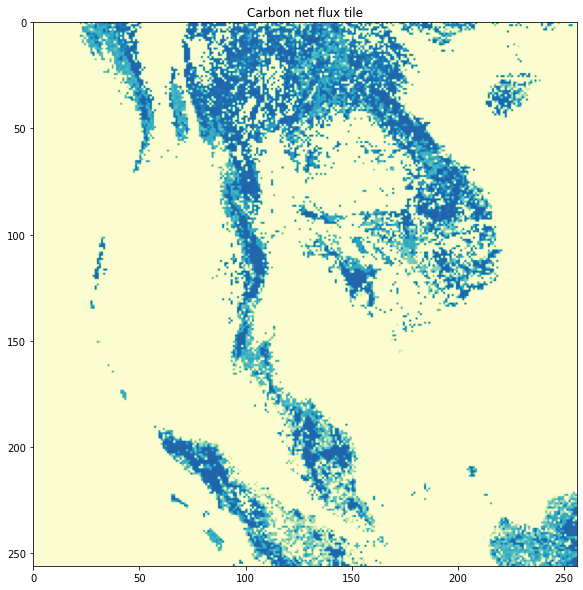

In [3]:
#check calculated risk map
with rio.open( 'https://tiles.globalforestwatch.org/gfw_forest_carbon_net_flux/v20210331/tcd_30/4/12/7.png') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    #ax.set_ylim((-5,40))
    #ax.set_xlim((60,100))
    rio.plot.show(dat, vmin=-10, vmax=350, cmap='YlGnBu', ax=ax, transform=src.transform)
    #gdf_india.plot(ax=ax, alpha=0.5, color='Orange', edgecolor='yellow')
    ax.set_title('Carbon net flux tile')

As has been commented above, for the prototype we will be using, temporarily, the crabon emissions estimations from earthstat and the deforestation risk map estimated in the 0_3_deforestation_indicator notebook.

In [14]:
# download carbon emissions dataset from earthstat
url = 'https://s3.us-east-2.amazonaws.com/earthstatdata/GHGEmissions_Geotiff.zip'
local_path = '../../datasets/raw/carbon_indicators'
if not os.path.isdir(local_path):
    os.mkdir(local_path)
print('Downloading dataset...')
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['tif'] if y.endswith(ending)] 
print(filenames)

Done
['GHGEmissions_Geotiff/food_kcal_emissions.tif', 'GHGEmissions_Geotiff/hectare_emissions.tif', 'GHGEmissions_Geotiff/kcal_emissions.tif', 'GHGEmissions_Geotiff/total_emissions.tif']


In [16]:
!gdalinfo $local_path/'GHGEmissions_Geotiff/total_emissions.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions.tif
       ../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions.tif.ovr
       ../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions.tif.aux.xml
Size is 4320, 2160
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-180.000000000000000,89.999999999989768)
Pixel Size = (0.083333333333329,-0.083333333333329)
Metadata:
  AREA_OR_POINT=

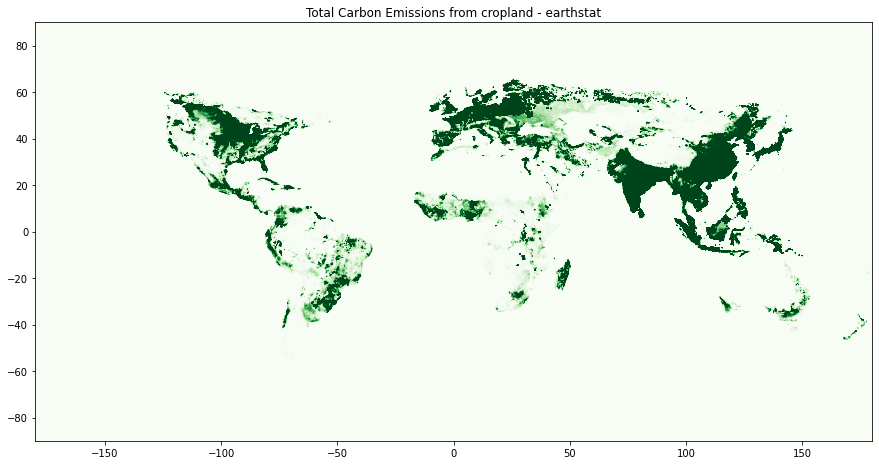

In [17]:
## visualize raster with rasterio
with rio.open( local_path + '/GHGEmissions_Geotiff/total_emissions.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    #ax.set_ylim((-5,40))
    #ax.set_xlim((60,100))
    rio.plot.show(dat, vmin=0, vmax=444, cmap='Greens', ax=ax, transform=src.transform)
    ax.set_title('Total Carbon Emissions from cropland - earthstat')

<a id='deforestation'></a>
### 2.2 Explore deforestation datasets

NOTE: A test deforestation dataset has been already produced as part of the deforestation indicator exploration.

In [19]:
!ls ../../datasets/processed/deforestation_indicators/deforestation_risk_ha_2018.tif

deforestation_metric_ha_2018_3857_test_location.tif
deforestation_metric_ha_2018_3857_test_location.tif.aux.xml
deforestation_risk_ha_2018_new_extent_3857.tif
deforestation_risk_ha_2018_new_extent.tif
deforestation_risk_ha_2018.tif


In [27]:
deforestation_path = '../../datasets/processed/deforestation_indicators'
!gdalinfo -stats -hist $deforestation_path/'deforestation_risk_ha_2018.tif'


Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/deforestation_indicators/deforestation_risk_ha_2018.tif
Size is 14063, 14995
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (100.024523992019894,2.919151450478214)
Pixel Size = (0.000269494417976,-0.000269495165055)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( 100.0245240,   2.9191515) (100d 1'28.29"E,  2d55' 8.95"N)
Lower Left  ( 100.0245240,  -1.1219285

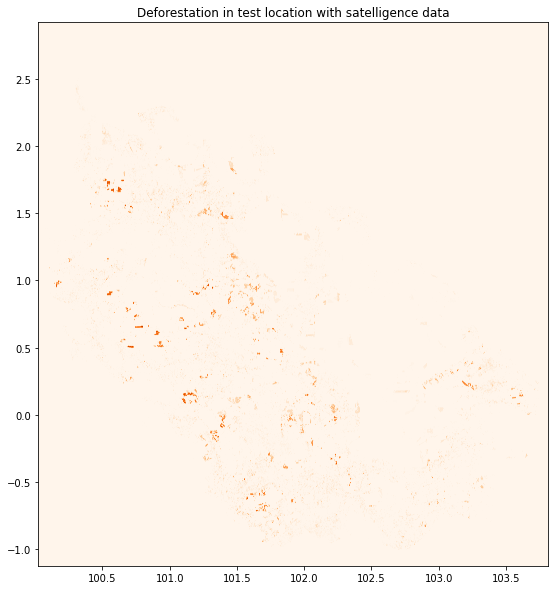

In [28]:
## visualize raster with rasterio
with rio.open( deforestation_path + '/deforestation_risk_ha_2018.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    ax.set_ylim((-1.1219285,2.9191515))
    ax.set_xlim((100.0245240,103.8144240))
    rio.plot.show(dat, vmin=1.9673679705447e-07, vmax=3.3993426768575e-05, cmap='Oranges', ax=ax, transform=src.transform)
    ax.set_title('Deforestation in test location with satelligence data')

<a id='risk_map'></a>
### 2.3 Calculate risk map

Before performing the calculations we need to put the two datasets into the same projection (in this case they are in the epsg4326 projection) and same extent:

In [31]:
# set the carbon emissions into the same extent as the deforestation risk map
!gdal_translate -projwin 100.024523992 2.91915145 103.814423992 -1.12192855 -of GTiff '../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions.tif' '../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions_clipped_4326.tif'

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


Once we have the two rasters with the same extent we need to get them into the same resolution. To do this we need to downsample the total carbon emissions from 10 km into 30m resolution. The workflow would be:

- get the total emissions by area unit - divide the total emissions by the pixel area
- donwsample the information from 10km to 30m
- multiply the downsampled raster by the pixel area to get the info in the total area



In [33]:
#get the total emissions by area unit
!gdal_calc.py -A '../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions_clipped_4326.tif' --outfile='../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions_clipped_4326_byArea.tif' --calc="A*(0.083333333333329*0.083333333333329)"

0.. 50.. 100 - Done


In [34]:
# downsample the generated data
!gdalwarp -s_srs EPSG:4326 -tr 0.000269494417976 0.000269494417976 -r near -of GTiff '../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions_clipped_4326_byArea.tif' '../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions_clipped_4326_byArea_30m.tif'

Creating output file that is 13915P x 14843L.
Processing ../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions_clipped_4326_byArea.tif [1/1] : 0Using internal nodata values (e.g. 3.40282e+38) for image ../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions_clipped_4326_byArea.tif.
Copying nodata values from source ../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions_clipped_4326_byArea.tif to destination ../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions_clipped_4326_byArea_30m.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [35]:
#normalise the downsample values by the pixel area
!gdal_calc.py -A '../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions_clipped_4326_byArea_30m.tif' --outfile='../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions_clipped_4326_30m.tif' --calc="A/(0.000269494417976*0.000269494417976)"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 

24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 

46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 

68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 

90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 

In [37]:
!gdalinfo '../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions_clipped_4326_30m.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions_clipped_4326_30m.tif
Size is 13915, 14843
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (99.999999999984084,2.999999999994714)
Pixel Size = (0.000269494417976,-0.000269494417976)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( 100.0000000,   3.0000000) (100d 0' 0.00"E,  3d 0' 0.00"N)
Lower Left  ( 100.0000000

In [38]:
# set the carbon emissions into the same extent as the deforestation risk map
!gdal_translate -projwin 100.0000000   3.0000000 103.7500148  -1.0001056 -of GTiff '../../datasets/processed/deforestation_indicators/deforestation_risk_ha_2018.tif' '../../datasets/processed/deforestation_indicators/deforestation_risk_ha_2018_new_xxtent_bio.tif'

Input file size is 14063, 14995
Warning 1: Computed -srcwin -91 -300 13915 14843 falls partially outside raster extent. Going on however.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [43]:
#calculate the ri
!gdal_calc.py -A '../../datasets/processed/deforestation_indicators/deforestation_risk_ha_2018_new_xxtent_bio.tif' -B '../../datasets/raw/carbon_indicators/GHGEmissions_Geotiff/total_emissions_clipped_4326_30m.tif' --outfile='../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg4326_tCO2e_v2.tif' --calc="A*(B)"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 

24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 

46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 

68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 

90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 

In [44]:
!gdalinfo -stats -hist '../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg4326_tCO2e_v2.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg4326_tCO2e_v2.tif
Size is 13915, 14843
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (99.999999999984084,2.999999999994714)
Pixel Size = (0.000269494417976,-0.000269495165055)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  ( 100.0000000,   3.0000000) (100d 0' 0.00"E,  3d 0' 0.00"N)
Lower Left  ( 100.0000000,  -1.00011

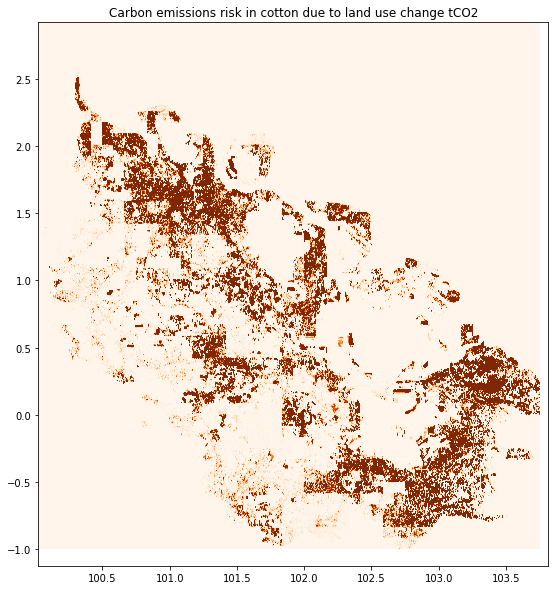

In [45]:
## visualize raster with rasterio
with rio.open('../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg4326_tCO2e_v2.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    ax.set_ylim((-1.1219285,2.9191515))
    ax.set_xlim((100.0245240,103.8144240))
    rio.plot.show(dat, vmin=0, vmax=822.80045408519, cmap='Oranges', ax=ax, transform=src.transform)
    ax.set_title('Carbon emissions risk in cotton due to land use change tCO2')

<a id='risk'></a>
## 3. Carbon emissions due to land use change metric

Now that we have the risk of carbon emissions due to land use change in cotton, we can determine the carbon emissions impact metris in a user test location.

    Carbon emissions due to land use change (tCO2e / year)  =  carbon emissions due to land use change risk map *   probability purchase area (unitless) 

<a id='purchase_area'></a>
### 3.1 Probability purchase area

We have already calculated a probability purchased area as part of the biodiversity indicator prototype, so we are going to use that one for the prototype:


In [48]:
!gdalinfo -stats -hist ../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_3857.tif

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_3857.tif
       ../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_3857.tif.aux.xml
Size is 13915, 14848
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popu

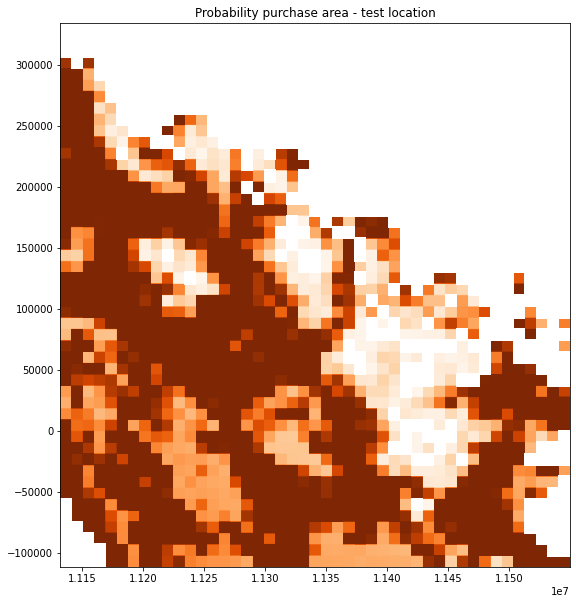

In [12]:
## visualize raster with rasterio
with rio.open('../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_3857.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    ax.set_ylim((-111328.8286,334111.1714))
    ax.set_xlim((1.113195e+07,1.154940e+07))
    rio.plot.show(dat, vmin=0, vmax=3.2353862778438e-08, cmap='Oranges', ax=ax, transform=src.transform)
    ax.set_title('Probability purchase area - test location')

<a id='carbon_metric'></a>
### 3.2 Calculation of the carbon emissions metric

Reproject the risk map from epsg4326 to epsg 3857. Steps:

- Normalise the raster by the pixel area
- Reproject
- Renormalise by the pixel area reprojected

In [4]:
# reproject risk map from epsg4326 to epsg 3857
#get the total emissions by area unit
!gdal_calc.py -A '../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg4326_tCO2e_v2.tif' --outfile='../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg4326_tCO2e_v2_byArea.tif' --calc="A*(0.000269494417976*0.000269494417976)"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 

24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 

46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 

68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 

90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 

In [5]:
#reproject raster
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:3857 -tr 30 30 -r near -of GTiff '../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg4326_tCO2e_v2_byArea.tif' '../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg3857_tCO2e_v2_byArea.tif'

Creating output file that is 13915P x 14848L.
Processing ../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg4326_tCO2e_v2_byArea.tif [1/1] : 0Using internal nodata values (e.g. 3.40282e+38) for image ../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg4326_tCO2e_v2_byArea.tif.
Copying nodata values from source ../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg4326_tCO2e_v2_byArea.tif to destination ../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg3857_tCO2e_v2_byArea.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [6]:
#renormalise by pixel area
!gdal_calc.py -A '../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg3857_tCO2e_v2_byArea.tif' --outfile='../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg3857_tCO2e.tif' --calc="A/(30*30)"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 

24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 

46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 

68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 

90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 

In [7]:
#check extendion 
!gdalinfo -stats -hist '../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg3857_tCO2e.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg3857_tCO2e.tif
Size is 13915, 14848
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
            ID["EPSG",1024]],


In [8]:
!gdalinfo -stats -hist '../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_3857.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_3857.tif
       ../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_3857.tif.aux.xml
Size is 13915, 14848
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popu

In [9]:
## calculate impact metric by multiplying the probability area and the risk map
#calculate the ri
!gdal_calc.py -A '../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_3857.tif' -B '../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg3857_tCO2e.tif' --outfile='../../datasets/processed/carbon_indicators/carbon_metric_cotton_test_location_tCO2.tif' --calc="A*B"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 

24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 24.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 25.. 

46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 46.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 47.. 

68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 68.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 69.. 

90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 

In [10]:
!gdalinfo -stats -hist '../../datasets/processed/carbon_indicators/carbon_metric_cotton_test_location_tCO2.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/carbon_indicators/carbon_metric_cotton_test_location_tCO2.tif
Size is 13915, 14848
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
            ID["EPSG",10

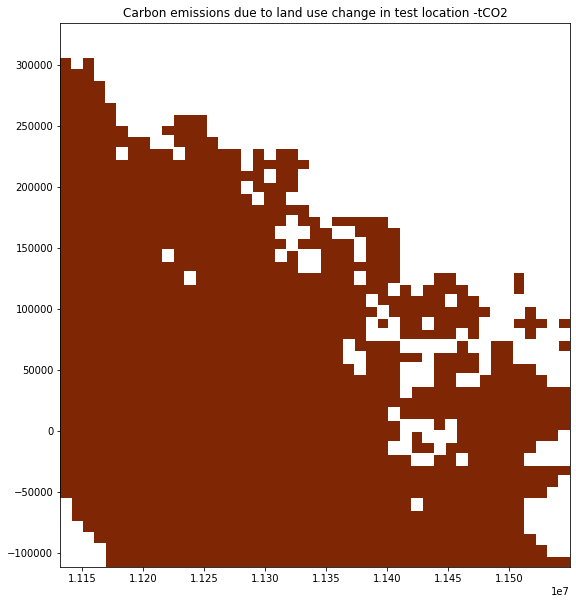

In [13]:
## visualize raster with rasterio
with rio.open('../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_3857.tif') as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15,10])
    ax.set_ylim((-111328.8286,334111.1714))
    ax.set_xlim((1.113195e+07,1.154940e+07))
    rio.plot.show(dat, vmin=0, vmax=6.0517936148474e-12, cmap='Oranges', ax=ax, transform=src.transform)
    ax.set_title('Carbon emissions due to land use change in test location -tCO2')

<a id='finalNotes'></a>
## 4. Final notes

The idea would be to present the risk map as an h3 layer. We are going to test the putput in h3 to produce a general workflow. 

In [24]:
import h3
import geopandas as gpd
import pandas as pd
import time
from rasterstats import gen_zonal_stats
from shapely.geometry import shape
import json

In [2]:
def generate_h3_features(geometry, res):
    """
    Generate h3 for geometry
    
    Input
    ------
    geometry: shapely.polygon or shapely.multipolygon
    
    Output
    ------
    gdf with H3_hexes
    """
    # Create an empty dataframe to write data into
    h3_df = pd.DataFrame([],columns=['h3_id'])
    if geometry.geom_type == 'MultiPolygon':
        district_polygon = list(geometry)
        for polygon in district_polygon:
            poly_geojson = gpd.GeoSeries([polygon]).__geo_interface__
            poly_geojson = poly_geojson['features'][0]['geometry'] 
            h3_hexes = h3.polyfill_geojson(poly_geojson, res)
            for h3_hex in h3_hexes:
                coords = h3.h3_set_to_multi_polygon([h3_hex], geo_json=True)
                yield {
                    "type": "Feature",
                    "properties": {"hexid": h3_hex},
                    "geometry": {"type": "Polygon", "coordinates": coords[0]},
                }
    elif geometry.geom_type == 'Polygon':
        poly_geojson = gpd.GeoSeries(geometry).__geo_interface__
        poly_geojson = poly_geojson['features'][0]['geometry']
        h3_hexes = h3.polyfill_geojson(poly_geojson, res)
        for h3_hex in h3_hexes:
            coords = h3.h3_set_to_multi_polygon([h3_hex], geo_json=True)
            yield {
                "type": "Feature",
                "properties": {"hexid": h3_hex},
                "geometry": {"type": "Polygon", "coordinates": coords[0]},
            }
    else:
        print('Shape is not a polygon or multypolygon.')

In [3]:
## import geometry to generate the h3 dataset - indonesia in our case
indonesia_gdf = gpd.read_file('../../datasets/raw/input_data_test/indonesia_test_shape_clip.shp')
indonesia_gdf

,fid,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,geometry
0,1.0,Rubber,None,2600.0,Indonesia,None,None,None,Origin country,Low,"POLYGON ((11206146.856 334111.171, 11237288.10..."


In [8]:
indonesia_gdf = indonesia_gdf.to_crs("EPSG:4326")

In [9]:
indonesia_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

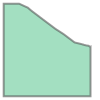

In [10]:
geom = indonesia_gdf['geometry'][0]
geom

In [28]:
# perform raster summary stats with the h3 feature
# risk map
start_time = time.time()
hexbin_generator = generate_h3_features(geom, 7)
raster_path = '../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg4326_tCO2e_v2.tif'

raster_stats_h3 = gen_zonal_stats(
    hexbin_generator,
    raster_path,
    stats="sum",
    prefix="carbon_risk_cotton_",
    geojson_out=True,
    all_touched=True
)
print("--- %s seconds ---" % (time.time() - start_time))



--- 0.00046253204345703125 seconds ---


In [29]:
#check output
for feature in raster_stats_h3:
    print(feature)
    break

{'type': 'Feature', 'properties': {'hexid': '87652a32cffffff', 'carbon_risk_cotton_sum': 0.0}, 'geometry': {'type': 'Polygon', 'coordinates': [[(100.1372562337611, 2.4572850311098993), (100.15048491735892, 2.453668479765659), (100.16035665594501, 2.463264782069973), (100.15700012870305, 2.4764784876717743), (100.14377080924186, 2.4800958171953615), (100.13389865315273, 2.470498662752815), (100.1372562337611, 2.4572850311098993)]]}}


In [31]:
#generate a dataframe with the elements
start_time = time.time()
h3_gdf_carbon_risk = pd.DataFrame([],columns=['h3_id', 'carbon_risk_cotton_sum', 'geometry'])
for feature in raster_stats_h3:
    h3_gdf_carbon_risk.loc[len(h3_gdf_carbon_risk)]=[
        feature['properties']['hexid'],
        feature['properties']['carbon_risk_cotton_sum'],
        shape(feature['geometry'])
            ]
print("--- %s seconds ---" % (time.time() - start_time))

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


--- 218.0820288658142 seconds ---


In [32]:
h3_gdf_carbon_risk.head()

,h3_id,carbon_risk_cotton_sum,geometry
0,87652aca0ffffff,0.000000e+00,"POLYGON ((101.0146876279456 2.684088218068172,..."
1,878cd04a2ffffff,1.588927e+06,POLYGON ((101.7790458343193 -0.754049935066211...
2,878cd28f4ffffff,4.910968e+04,POLYGON ((101.9389992873756 -0.422611654062353...
3,878cd36d5ffffff,0.000000e+00,POLYGON ((100.4025663737867 0.1120100202788547...
4,876521a5dffffff,7.038545e+06,POLYGON ((101.6691276528655 0.6084388297567048...


In [33]:
h3_gdf_carbon_risk.to_csv('../../datasets/processed/carbon_indicators/carbon_risk_cotton_epsg4326_tCO2e_v2_h3.csv')

In [36]:
# do the h3 for the probability purchase area - user data

# perform raster summary stats with the h3 feature
# risk map
start_time = time.time()
hexbin_generator = generate_h3_features(geom, 7)
raster_path ='../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_4326.tif'

raster_stats_h3 = gen_zonal_stats(
    hexbin_generator,
    raster_path,
    stats="max",
    prefix="purchase_area_",
    geojson_out=True,
    all_touched=True
)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00016689300537109375 seconds ---


In [37]:
#check output
for feature in raster_stats_h3:
    print(feature)
    break

{'type': 'Feature', 'properties': {'hexid': '87652a32cffffff', 'purchase_area_max': 3.6931975699872055e-08}, 'geometry': {'type': 'Polygon', 'coordinates': [[(100.1372562337611, 2.4572850311098993), (100.15048491735892, 2.453668479765659), (100.16035665594501, 2.463264782069973), (100.15700012870305, 2.4764784876717743), (100.14377080924186, 2.4800958171953615), (100.13389865315273, 2.470498662752815), (100.1372562337611, 2.4572850311098993)]]}}


In [38]:
#generate a dataframe with the elements
start_time = time.time()
h3_gdf_purchase = pd.DataFrame([],columns=['h3_id', 'purchase_area_max', 'geometry'])
for feature in raster_stats_h3:
    h3_gdf_purchase.loc[len(h3_gdf_purchase)]=[
        feature['properties']['hexid'],
        feature['properties']['purchase_area_max'],
        shape(feature['geometry'])
            ]
print("--- %s seconds ---" % (time.time() - start_time))

--- 252.22981548309326 seconds ---


In [39]:
h3_gdf_purchase.to_csv('../../datasets/processed/carbon_indicators/probability_purchase_area_h3.csv')

In [ ]:
#obtain the carbon impact in h3
# do the h3 for the probability purchase area - user data

# perform raster summary stats with the h3 feature
# risk map
start_time = time.time()
hexbin_generator = generate_h3_features(geom, 7)
raster_path ='../../datasets/processed/probability_map/purchase_area_distribution_rubber_indonesia_4326.tif'

raster_stats_h3 = gen_zonal_stats(
    hexbin_generator,
    raster_path,
    stats="max",
    prefix="purchase_area_",
    geojson_out=True,
    all_touched=True
)
print("--- %s seconds ---" % (time.time() - start_time))